In [71]:
# CAPTURE/EXTRACT STATIC FRAMES FROM VIDEO

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

from collections import deque

# print(cv2.__version__)
# vidcap = cv2.VideoCapture('challenge-Copy1.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# while success:
#   cv2.imwrite("syc_frame%d.jpg" % count, image)     # save frame as JPEG file
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1

In [72]:
# CANNY EDGE DETECTION FUNCTION
def my_ced(jpg_image):

    # Read in the image and convert to hls
    image = mpimg.imread(jpg_image)
    img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
   # White color mask
    Wlower = np.uint8([  0, 200,   0])
    Wupper = np.uint8([255, 255, 255])
    White_Mask = cv2.inRange(img_hls, Wlower, Wupper)
    # Yellow color mask
    Ylower = np.uint8([ 0,   0, 100])
    Yupper = np.uint8([ 50, 255, 255])
    Yellow_Mask = cv2.inRange(img_hls, Ylower, Yupper)
    # Combine the mask
    Mask_wy = cv2.bitwise_or(White_Mask, Yellow_Mask)
    HSL_wy = cv2.bitwise_and(image, image, mask = Mask_wy)

    # Filter white and yellow

    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(HSL_wy,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 200
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(edges, cmap='Greys_r')
    print('Canny Edge Detection:' + jpg_image)
    plt.show()
    return edges


In [73]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

class my_mpht_so(object):
    def __init__(self, m_parm, b_parm, l_parm):
        self.m_parm = m_parm
        self.b_parm = b_parm
        self.l_parm = l_parm        

def my_mpht(jpg_image,mc_in,edges):
    
    # Read in the image
    image = mpimg.imread(jpg_image)
    
    # make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)    
    
    # Define a region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

    # obtain these coordinates using WebPlotDigitizer at https://apps.automeris.io/wpd/
    mask_cords = mc_in

    mask_cords = np.round(mask_cords)
    mask_cords = mask_cords.astype(int)
    mask_cords = tuple(map(tuple,mask_cords))

    # Draw a line with thickness of 4 px
    ic = 1
    while (ic<len(mask_cords)):
        region_select = cv2.line(region_select,mask_cords[ic-1],mask_cords[ic],(255,0,0),4)
        ic = ic+1

    region_select = cv2.line(region_select,mask_cords[-1],mask_cords[0],(255,0,0),4)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255

    # This time we are defining a n sided polygon to mask
    imshape = image.shape
    vertices = np.array([mask_cords], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 2
    min_line_length = 10
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
    m_parm = []
    b_parm = []
    l_parm = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            m_parm.append((y2-y1)/(x2-x1))
            b_parm.append(y1-x1*(y2-y1)/(x2-x1))
            l_parm.append(np.sqrt((y2-y1)**2+(x2-x1)**2))       

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(region_select, cmap='Greys_r')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(combo)

    print('Masking and P-Hough Transform:' + jpg_image)
    plt.show()
    return my_mpht_so(m_parm, b_parm, l_parm)
    


In [74]:
nf = 25
mmp_nv = deque(maxlen=nf)
mbp_nv = deque(maxlen=nf)        
mmp_pv = deque(maxlen=nf)
mbp_pv = deque(maxlen=nf)        

# FINAL LANE DETECTION LINES WITH TRANSPARENCY
def my_fld(jpg_image,eps_in):
    
    global mmp_nv
    global mbp_nv
    global mmp_pv
    global mbp_pv    
    
    # DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
    # USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
    # ONCE SORTED DETERMINE 
    # > weighted-AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
    # > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) and Y=0.625*540 DETERMINE CORRESPONDING X

    # Read in the image
    image = mpimg.imread(jpg_image)
    # make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    y1 = int(round(0.65*ysize)) # slightly lower than middle
    y2 = ysize     
    
    # EPS PARMS
    m_parm = eps_in.m_parm
    b_parm = eps_in.b_parm
    l_parm = eps_in.l_parm    

    # weighted average slope and intercept for left and right lanes
    m_parm = np.asarray(m_parm)
    b_parm = np.asarray(b_parm)
    l_parm = np.asarray(l_parm)

    mp_sort = sorted(m_parm)
    b_sort = b_parm[np.argsort(m_parm)]    
    l_sort = l_parm[np.argsort(m_parm)]

    # negative slope
    mp_neg = list(filter(lambda x: x < 0, mp_sort)) 
    mp_neg_len = len(mp_neg)

    mp_neg_b = b_sort[0:mp_neg_len]    
    mp_neg_l = l_sort[0:mp_neg_len]

    # weighted average slope and intercept
    mmp_neg =  np.dot(mp_neg_l, mp_neg)/np.sum(mp_neg_l)
    mmp_nv.append(mmp_neg)
    mmp_nv_mn = np.mean(mmp_nv) # averaging over 50 frames

    mbp_neg =  np.dot(mp_neg_l, mp_neg_b)/np.sum(mp_neg_l)
    mbp_nv.append(mbp_neg)
    mbp_nv_mn = np.mean(mbp_nv) # averaging over 50 frames

    lmn_x1 = int(round((y1-mbp_nv_mn)/mmp_nv_mn))
    lmn_x1y1 = (lmn_x1,y1)

    lmn_x2 = int(round((y2-mbp_nv_mn)/mmp_nv_mn))
    lmn_x2y2 = (lmn_x2,y2)

    # positive slope
    mp_pos = mp_sort[mp_neg_len:]
    mp_pos_b = b_sort[mp_neg_len:]
    mp_pos_l = l_sort[mp_neg_len:]

    # weighted average slope and intercept    
    mmp_pos =  np.dot(mp_pos_l, mp_pos)/np.sum(mp_pos_l)
    mmp_pv.append(mmp_pos)
    mmp_pv_mn = np.mean(mmp_pv) # averaging over 50 frames
    
    mbp_pos =  np.dot(mp_pos_l, mp_pos_b)/np.sum(mp_pos_l)
    mbp_pv.append(mbp_pos)
    mbp_pv_mn = np.mean(mbp_pv) # averaging over 50 frames
    
    lmp_x1 = int(round((y1-mbp_pv_mn)/mmp_pv_mn))
    lmp_x1y1 = (lmp_x1,y1)

    lmp_x2 = int(round((y2-mbp_pv_mn)/mmp_pv_mn))
    lmp_x2y2 = (lmp_x2,y2)
    
    lane_select = np.copy(image)
    # Draw a line with thickness of 4 px
    lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),18)
    lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),18)    
    alpha = 0.4  # Transparency factor.
    lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)
    
    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(lane_select)
    
    print('Final Lane Detection and Transparency:' + jpg_image)
    plt.show()
    
    # SAVING FINAL OUTPUT
    fig_s = plt.figure()
    fig_s.set_size_inches(18.5, 10.5)
    ax_s = plt.gca()
    ax_s.imshow(lane_select)
    ax_s.axis('off')    
    plt.savefig('fo_'+jpg_image)
    print('Final Output Saved:' + jpg_image)
    

Canny Edge Detection:syc_frame0.jpg


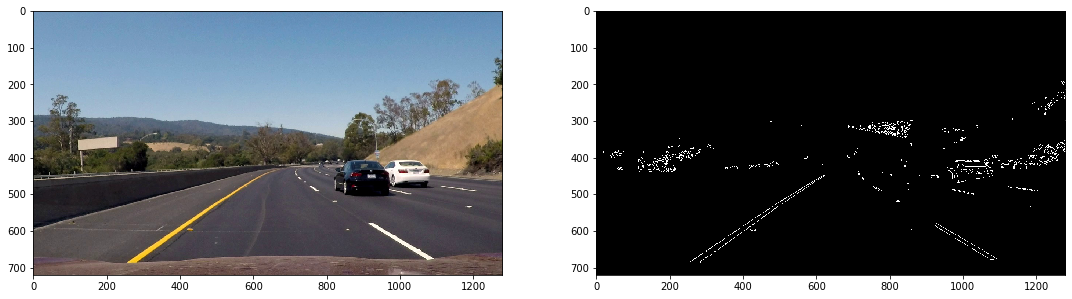

Masking and P-Hough Transform:syc_frame0.jpg


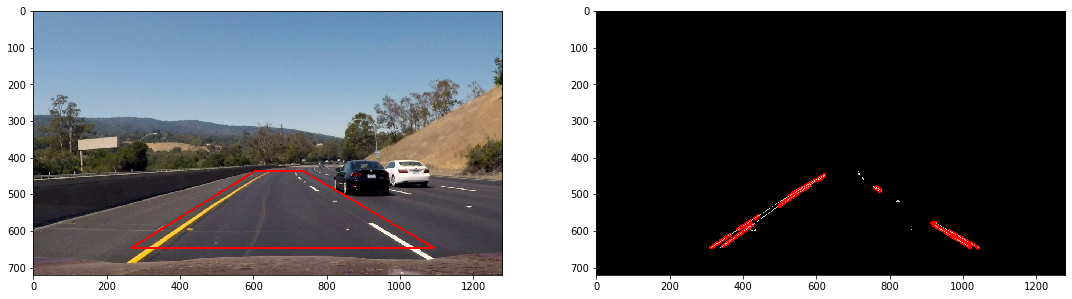

Final Lane Detection and Transparency:syc_frame0.jpg


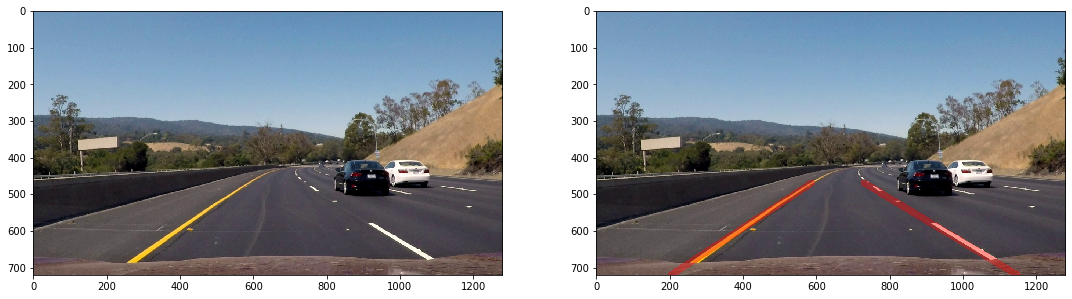

Final Output Saved:syc_frame0.jpg


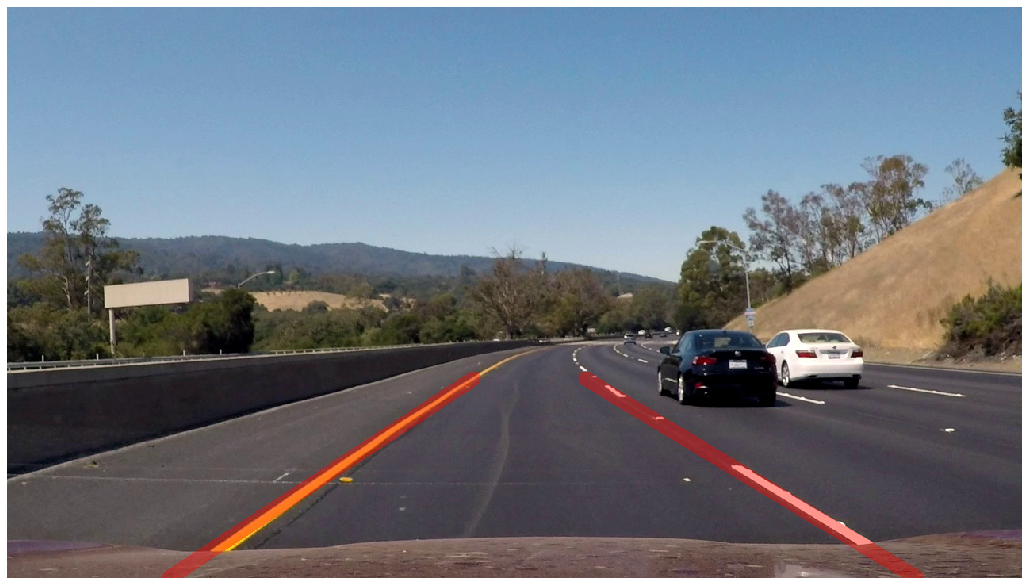

In [75]:
# PIPELINE TO EXECUTE
# > CANNY EDGE DETECTION FUNCTION
# > MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES
# > FINAL LANE DETECTION LINES WITH TRANSPARENCY
# ON EACH INDIVIDUAL STATIC FRAMES CAPTURED FROM THE VIDEO

ic = 0
# max:250
while (ic<1):
    
    skip_fs = [147, 148, 149]
    if (ic in set(skip_fs)):
        print('skipping frame:'+str(ic)+'.jpg')
    else:
        # CURRENT STATIC FRAME/IMAGE
        jpg_image = 'syc_frame'+str(ic)+'.jpg'

        # CANNY EDGE DETECTION FUNCTION
        cur_edges = my_ced(jpg_image)

        # Define a region of interest 
        # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

        mc_in = [(267.7272727272727, 645),
                (605.9779614325068, 434.71074380165294),
                (732.6446280991734, 434.71074380165294),
                (1091.0468319559227, 645)]

        # MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES    
        my_mpht_out = my_mpht(jpg_image,mc_in,cur_edges)
        
        # FINAL LANE DETECTION LINES WITH TRANSPARENCY
        my_fld(jpg_image,my_mpht_out)

    ic = ic+1

In [76]:
# # MAKING VIDEO FROM FINAL OUTPUT FRAMES

# fo_syc_frame0 = cv2.imread('fo_syc_frame0.jpg')

# vid_height, vid_width, vid_layers =  fo_syc_frame0.shape

# # fourcc = cv2.VideoWriter_fourcc(*'X264')
# fourcc = cv2.VideoWriter_fourcc(*'MP4V')
# vid_out = cv2.VideoWriter('Challenge_fo.mp4',fourcc,25,(vid_width,vid_height),True)

# ic2 = 0
# # max:250

# while ((ic2<250)):
    
#     skip_fs = [147, 148, 149]
#     if (ic2 in set(skip_fs)):
#         print('skipping frame:'+str(ic2)+'.jpg')
#     else:
#         print(ic2)
#         cur_img = cv2.imread('fo_syc_frame'+str(ic2)+'.jpg')
#         vid_out.write(cur_img)
        
#     ic2 = ic2+1

# # cv2.destroyAllWindows()
# vid_out.release()